In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow.keras.utils as ku
import tensorflow as tf
import numpy as np
import glob
import random

In [21]:
read_files = glob.glob("*.txt")

with open("corpus.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

In [2]:
tokenizer = Tokenizer()
data = open('corpus.txt').read()

corpus = data.lower().split('\n ')
tokenizer.fit_on_texts(corpus)
num_of_unique_words = len(tokenizer.word_index) + 1
print('Number of unique words: '+ str(num_of_unique_words))

Number of unique words: 5547


In [20]:
n = 20
input_texts = []
for i in range(len(corpus)):
    sentence_list = corpus[i].rstrip(' ').split(' ')
    if len(sentence_list) > n:
        startpoint = len(sentence_list)-(n-1)
        endpoint = n
    else:
        startpoint = 1
        endpoint = len(sentence_list)
            
    for j in range(startpoint):
        for k in range(endpoint):
            line = sentence_list[j+k:j+n]
            input_texts.append(line)

random.shuffle(input_texts)
print('Number of samples: '+str(len(input_texts)))

Number of samples: 673223


In [12]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=n, padding='pre'))

predictors = input_sequences[:,:-1]
labels = input_sequences[:,-1]

In [8]:
class mycallback(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs.get('accuracy') > 0.9:
            print('Stopping early')
            self.model.stop_training = True
            
callback1 = mycallback()

callback2 = EarlyStopping(monitor='accuracy', min_delta = 0.002)

In [9]:
model = Sequential([
    Embedding(num_of_unique_words, 100, input_length=n-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.3),
    LSTM(100),
    Dense(num_of_unique_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(num_of_unique_words, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            554700    
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 300)            301200    
_________________________________________________________________
dropout (Dropout)            (None, 7, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 2773)              280073    
_________________________________________________________________
dense_1 (Dense)              (None, 5547)              15387378  
Total params: 16,683,751
Trainable params: 16,683,751
Non-trainable params: 0
____________________________________________

In [13]:
history = model.fit(predictors,labels, epochs=150, callbacks=[callback1, callback2], 
                    batch_size=300, validation_split=0.15)

Epoch 1/150
1229/1229 [==============================] - 32s 26ms/step - loss: 5.8038 - accuracy: 0.0691 - val_loss: 5.4928 - val_accuracy: 0.1037
Epoch 2/150
1229/1229 [==============================] - 31s 26ms/step - loss: 5.2779 - accuracy: 0.1190 - val_loss: 5.0933 - val_accuracy: 0.1349
Epoch 3/150
1229/1229 [==============================] - 31s 26ms/step - loss: 4.8870 - accuracy: 0.1492 - val_loss: 4.7467 - val_accuracy: 0.1655
Epoch 4/150
1229/1229 [==============================] - 31s 25ms/step - loss: 4.5500 - accuracy: 0.1794 - val_loss: 4.4568 - val_accuracy: 0.1933
Epoch 5/150
1229/1229 [==============================] - 32s 26ms/step - loss: 4.2566 - accuracy: 0.2133 - val_loss: 4.1871 - val_accuracy: 0.2270
Epoch 6/150
1229/1229 [==============================] - 31s 25ms/step - loss: 4.0004 - accuracy: 0.2488 - val_loss: 3.9792 - val_accuracy: 0.2580
Epoch 7/150
1229/1229 [==============================] - 31s 25ms/step - loss: 3.7731 - accuracy: 0.2843 - val_loss: 3

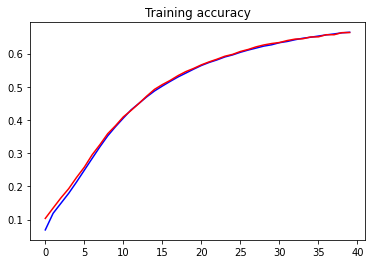

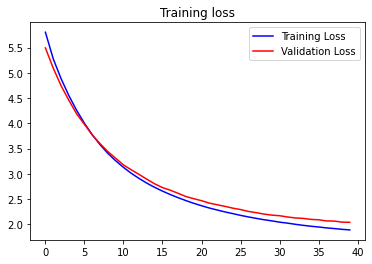

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
model.save('tmp/jrebot', overwrite=True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tmp/jrebot/assets


In [63]:
seed = "elon musk"

next_words = 50
phrase = []
def randomize_word(sequence, temperature=1):
    probs = model.predict(sequence)
    rescaled_logits = tf.math.log(probs)/temperature
    word_id = tf.random.categorical(rescaled_logits, num_samples=1)

    return word_id


for _ in range(next_words):
    phrase = seed.split(' ')[-(n-1)::]
    sequence = tokenizer.texts_to_sequences([phrase])
    sequence = pad_sequences(sequence, maxlen=n-1, padding='pre')
    #predicted = model.predict_classes(sequence)
    predicted = randomize_word(sequence,temperature=0.5)
    next_word = ''
    for word,index in tokenizer.word_index.items():
        if index == predicted[0]:
            next_word = word
            break
    seed += ' ' + next_word

print(seed)
    

elon musk is talking about these driverless cars one of the things he's saying that i didn't know when we were kids and today i do have to learn how to play parts to a guy's got his own fucking jet got me in all from gambling mean that's that's that's bizarre
